### Наша цель - уменьшить количество уникальных параметров в сверточной нейросети, при этом постараться не сильно уменьшить точность модели.

####  Обучать модель и проверять точность будем на датасете MNIST.

## 1. Давайте обращать в 0 околонулевые веса(~<e-2)

In [1]:
import os
import sys

import blosc
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from sklearn.cluster import KMeans
%matplotlib inline

sys.path.append('..')

from dataset import Dataset, DatasetIndex, Batch, action, model
from dataset.dataset.opensets import MNIST
from dataset.dataset.image import ImagesBatch

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

### Создадим Batch-class с моделью и пайплайн для обучения и оценки качества.

### Про модель:
* 2 convolution layers:
    * first layer: 
        kernel = 7x7x1, num_filters = 16 => 784 weights
    * second layer:
         kernel = 5x5x16, num_filters = 32 => 12800 weights
* 2 dense layers:
    * first layer: num_filters = 256, num_inputs = 128 => 32768 weights
    * second layer: num_filters = 10, num_inputs = 256 => 2560 weights
    
### Всего весов: 48912

In [3]:
class MnistBatch(ImagesBatch):
    @model(mode='dynamic')
    def static_nn(self):
        graph = tf.Graph()
        with graph.as_default():
            input_images = tf.placeholder(tf.float32, [None, 28, 28, 1])
            input_labels = tf.placeholder(tf.int32, [None])

            net = tf.layers.conv2d(inputs=input_images, filters=16, kernel_size=(7, 7), strides=(2, 2), name='first', \
                                   padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            net = tf.layers.max_pooling2d(net, pool_size=(4, 4), strides=(2, 2))#, padding='SAME')
            net = tf.nn.relu(net)

            net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(5, 5), strides=(1, 1), name='second',\
                                   padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            net = tf.layers.max_pooling2d(net, pool_size=(3, 3), strides=(2, 2))
            net = tf.nn.relu(net)

            net = tf.contrib.layers.flatten(net)
            layer2 = tf.layers.dense(net, units=256, activation=tf.nn.relu, name='dense_1')

            model_output = tf.layers.dense(layer2, units=10, name='dense_2')
            encoded_labels = tf.one_hot(input_labels, depth=10)

            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=encoded_labels, logits=model_output))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

            prediction = tf.argmax(model_output, 1)
            correct_prediction = tf.equal(prediction, tf.argmax(encoded_labels, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
            session = tf.Session()
            session.run(tf.global_variables_initializer())
        return [[input_images, input_labels], [optimizer, cost, accuracy, session]]

    @action(model='static_nn')
    def train_nn(self, model, train_loss):
        input_images, input_labels = model[0]
        optimizer, cost, accuracy, sess = model[1]
        _, loss = sess.run([optimizer, cost], feed_dict={input_images: self.images, input_labels: self.labels})
        train_loss.append(loss)
        return self

    @action(model='static_nn')
    def print_accuracy(self, model, acc):
        input_images, input_labels = model[0]
        optimizer, cost, accuracy, sess = model[1]
        acc.append(sess.run(accuracy, feed_dict={input_images: self.images, input_labels: self.labels}))
        return self


In [4]:
mnist = MNIST(batch_class=MnistBatch)

Downloaded t10k-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz


In [5]:
acc = []
train_loss = []
train_pipeline = (mnist.train.
              p.
              train_nn(train_loss))
test_pipeline = (mnist.test.
             p.
             import_model("static_nn", train_pipeline).
             print_accuracy(acc))

### Обучим модель и построим график accuracy

In [6]:
MAX_ITER = 600
for curr_iter in tqn(range(1, MAX_ITER + 1)):
    train_pipeline.next_batch(100, n_epochs=None, shuffle=True)
    test_pipeline.next_batch(100, n_epochs=None, shuffle=True)

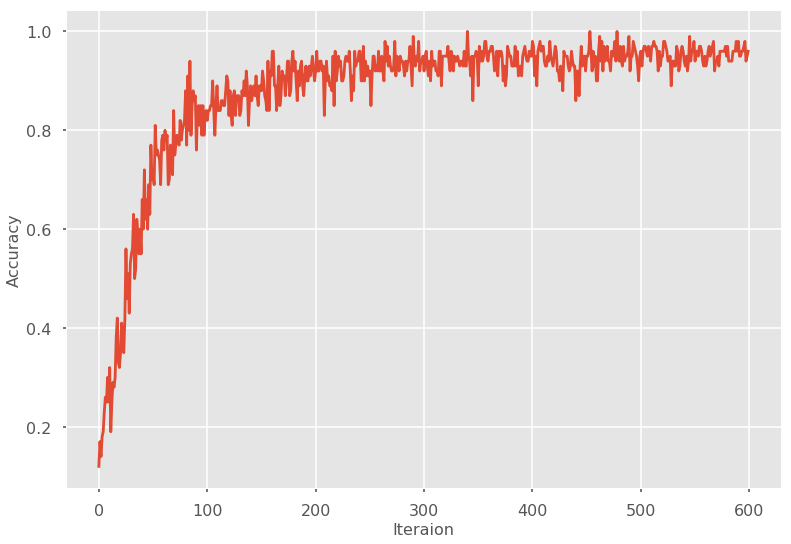

In [7]:
plt.xlabel('Iteraion', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(acc)

### Возьмем из нашей модели сессию и граф

In [12]:
acc

[0.12,
 0.17,
 0.14,
 0.18000001,
 0.19,
 0.23,
 0.25999999,
 0.25,
 0.30000001,
 0.25,
 0.31999999,
 0.19,
 0.25,
 0.28999999,
 0.28,
 0.30000001,
 0.38,
 0.41999999,
 0.33000001,
 0.31999999,
 0.34999999,
 0.41,
 0.37,
 0.34999999,
 0.41999999,
 0.56,
 0.46000001,
 0.50999999,
 0.43000001,
 0.52999997,
 0.55000001,
 0.56,
 0.63,
 0.5,
 0.51999998,
 0.62,
 0.58999997,
 0.55000001,
 0.60000002,
 0.55000001,
 0.66000003,
 0.60000002,
 0.72000003,
 0.62,
 0.66000003,
 0.60000002,
 0.69,
 0.63,
 0.76999998,
 0.69999999,
 0.70999998,
 0.69,
 0.81,
 0.75,
 0.75999999,
 0.75,
 0.74000001,
 0.69,
 0.77999997,
 0.79000002,
 0.75999999,
 0.80000001,
 0.77999997,
 0.79000002,
 0.69,
 0.69999999,
 0.76999998,
 0.73000002,
 0.70999998,
 0.83999997,
 0.75,
 0.76999998,
 0.79000002,
 0.77999997,
 0.76999998,
 0.81999999,
 0.77999997,
 0.80000001,
 0.81,
 0.81999999,
 0.88,
 0.76999998,
 0.91000003,
 0.80000001,
 0.94,
 0.79000002,
 0.85000002,
 0.88,
 0.86000001,
 0.87,
 0.75999999,
 0.83999997,
 0.

In [8]:
sess = train_pipeline.get_model_by_name("static_nn")[-1][-1]
graph = sess.graph

### Найдем все веса и будем занулять околонулевые веса, постепенно увеличивая порог

In [9]:
weights, biases = [], []
variables = graph.get_collection('trainable_variables')
weights.append(sess.run(variables[::2]))
biases.append(sess.run(variables[1::2]))

weights = np.array(weights[0])
biases = np.array(biases[0])
percentage = []
accuracy = []
for const in tqn(np.linspace(1e-2, 9e-2)):
    zeros_on_layer = []
    for i in range(len(weights)):
        weight_ind = np.where(np.abs(weights[i]) < const)
        zeros_on_layer.append(len(weight_ind[0]) / np.array(weights[i].shape).prod())
        weights[i][weight_ind] = 0
        biases[i][np.where(np.abs(biases[i]) < const)] = 0
    percentage.append(zeros_on_layer)
    
    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)
    test_pipeline.next_batch(100, shuffle=True)
    accuracy.append(acc[-1])

### Посмотрим как процент зануленных весов влияет на точность

In [10]:
a = np.linspace(1e-2,9e-2)

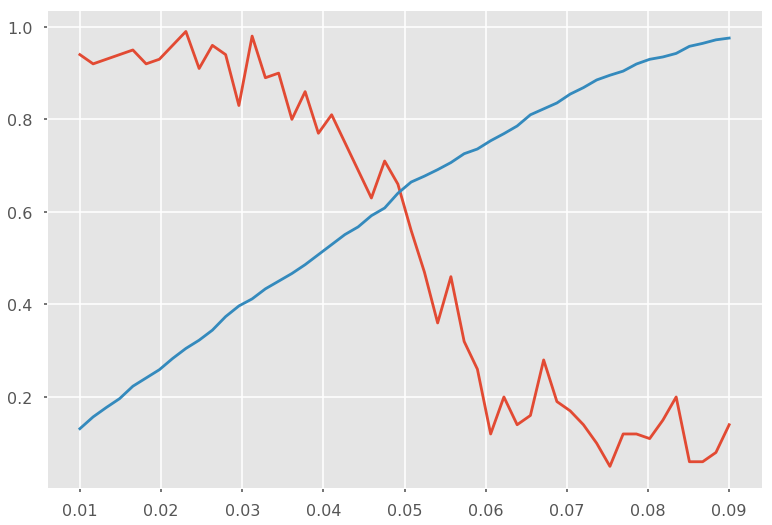

In [20]:
plt.plot(a, accuracy)
plt.plot(a, np.array(percentage)[:,0])

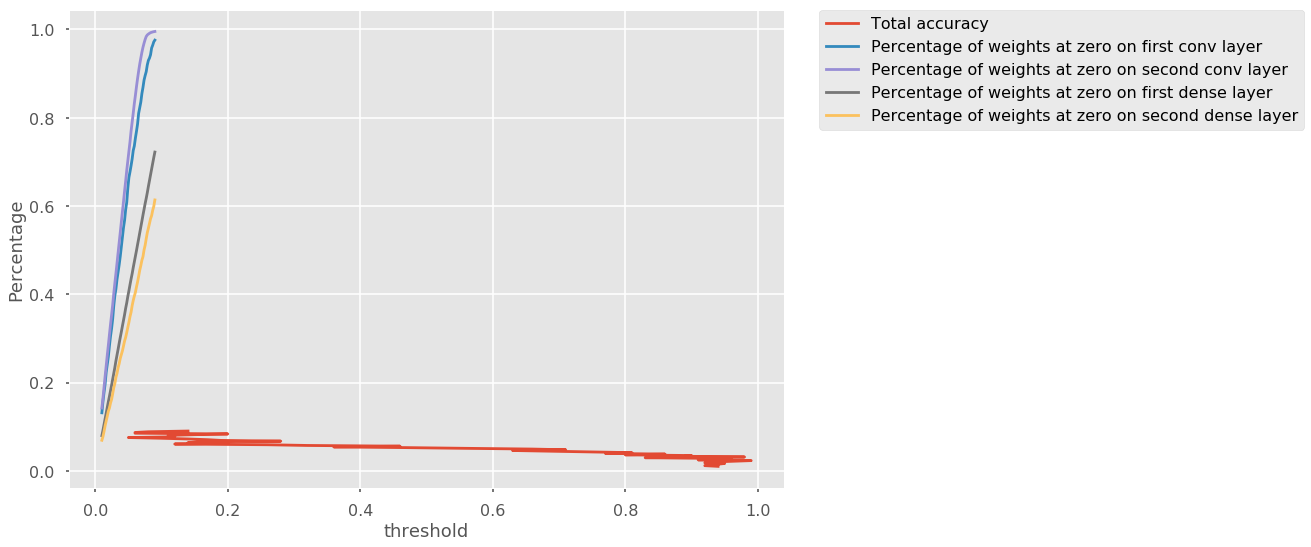

In [11]:
plt.xlabel('threshold', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.plot(a, a, label='Total accuracy')
plt.plot( a,np.array(percentage)[:,0], label='Percentage of weights at zero on first conv layer')
plt.plot( a,np.array(percentage)[:,1], label='Percentage of weights at zero on second conv layer')
plt.plot( a,np.array(percentage)[:,2], label='Percentage of weights at zero on first dense layer')
plt.plot( a,np.array(percentage)[:,3], label='Percentage of weights at zero on second dense layer')
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## 2. Разделим веса каждого слоя на класера, тем самым уменьшив количество уникальных значений весов в соле, что позволит нам более оптимально их хранить.

### Заново натренируем модель и снова возьмем из неё сессию и граф

In [8]:
sess = train_pipeline.get_model_by_name("static_nn")[-1][-1]
graph = sess.graph

### Снова получим веса модели и сохраним их

In [9]:
weights_global, biases_global = [], []
variables = graph.get_collection('trainable_variables')
weights_global.append(sess.run(variables[::2]))
biases_global.append(sess.run(variables[1::2]))

weights_global = np.array(weights_global[0])
biases_global = np.array(biases_global[0])
weights = []
biases = []
weights[:] = weights_global
biases[:] = biases_global

### Для того, чтобы проводить сразу несколько эксперементов, не переобучая модель, сделаем функцию для восстановления начального состояния модели

In [10]:
def clear():
    weights[:] = weights_global
    biases[:] = biases_global
    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)

### Давайте посмотрим, как уменьшение количества кластеров будет влиять на точноть наших предсказаний

In [11]:
accuracy = []
save = []
clasters = np.hstack((np.linspace(30, 4, 15, dtype=np.int32), \
                      np.linspace(100, 4, 15, dtype=np.int32), \
                      np.linspace(500, 4, 15, dtype=np.int32), \
                      np.linspace(50, 4, 15, dtype=np.int32))).reshape(4,-1).T

uniq = (sum([len(np.unique(i)) for i in weights]) + sum([len(np.unique(i)) for i in biases]))

for claster in tqn(zip(clasters,np.array([2, 2, 2, 2]*15).reshape(15, 4))):
    
    weights_clust, bias_clust = claster
    save_layers = []
    for i in range(4):
        kmeans = KMeans(weights_clust[i]).fit(weights[i].reshape(-1, 1))
        shape = weights[i].shape 
        weights[i] = kmeans.cluster_centers_[kmeans.predict(weights[i].reshape(-1, 1))].reshape(shape)
        kmeans = KMeans(bias_clust[i]).fit(biases[i].reshape(-1, 1))
        shape = biases[i].shape
        biases[i] = kmeans.cluster_centers_[kmeans.predict(biases[i].reshape(-1, 1))].reshape(shape)

    save.append((sum(weights_clust) + sum(bias_clust)) / uniq)

    assign = []
    for i in range(0, 7, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], weights[i//2]))
    for i in range(1, 8, 2):
        assign.append(tf.assign(graph.get_collection('trainable_variables')[i], biases[i//2]))
    sess.run(assign)
    test_pipeline.next_batch(100)
    accuracy.append(acc[-1])
    clear()

### График, показывающий зависимость accuracy от процента одинаковых весов.

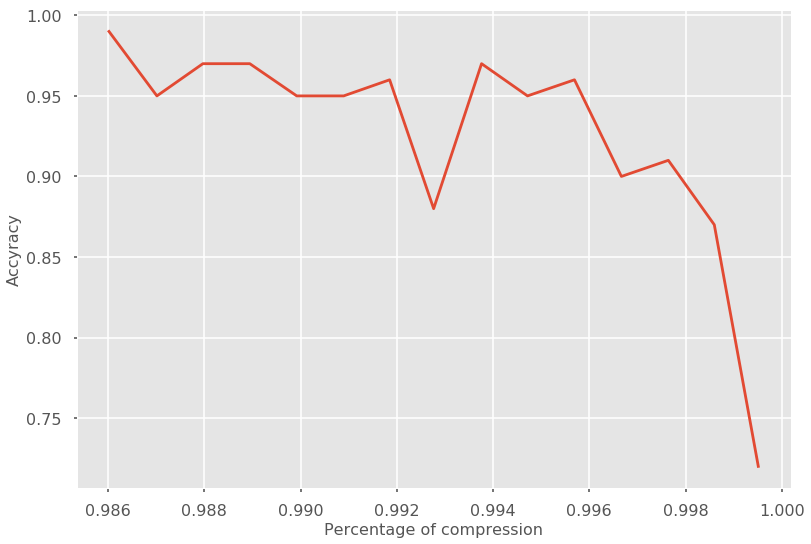

In [12]:
percent_save = 1 - np.array(save)
plt.xlabel('Percentage of compression', fontsize=16)
plt.ylabel('Accyracy', fontsize=16)
plt.plot(percent_save, accuracy)